# Proyecto 1 Reconocimiento de Patrones

José Julián Camacho Hernández

Leonardo Guillén Fernández

## Regresión Logística

In [336]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve


In [372]:
accuracy_data = []
precision_data = []
recall_data = []
auc_data = []

accuracy_sklearn = []
precision_sklearn = []
recall_sklearn = []
auc_sklearn = []

In [404]:
class LogisticRegression:
    def __init__(self, lr=0.01, num_iter=100000, fit_intercept=True):
        self.lr = lr
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept
       

    def __add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)

    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def __loss(self, h, y):
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()

    def fit(self, X, y):
        if self.fit_intercept:
            X = self.__add_intercept(X)

        # weights initialization
        self.w = np.zeros(X.shape[1])

        for i in range(self.num_iter):
            z = np.dot(X, self.w)
            h = self.__sigmoid(z)
            gradient = np.dot(X.T, (h-y)) / y.size
            #print(gradient.shape, self.w.shape, z.shape,h.shape)
            #gradient = (h - y) / y.size
            self.w -= self.lr * gradient

    def predict_prob(self, X):
        if self.fit_intercept:
            X = self.__add_intercept(X)

        return self.__sigmoid(np.dot(X, self.w))

    def predict(self, X, threshold):
        return self.predict_prob(X) >= threshold
    def score(self, y_pred,y_test):
        return float(sum(y_pred == y_test)) / float(len(y_test))


### Set de datos Red Wine Quality

In [405]:
# Cargar los datos de Red Wine Quality
data_wines = pd.read_csv("winequality-red.csv")

#======  Feature Engineering  ======#

# Convertir la calidad en un problema de clasificación binaria
data_wines['quality'] = np.where(data_wines['quality'] > 5, 1, 0)  

# Estandarización de los datos
X = data_wines.drop('quality', axis=1)
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
scaler = StandardScaler()
scaler.fit(X[numeric_cols])
scaled_data = scaler.transform(X[numeric_cols])
data_wines[numeric_cols] = scaled_data
#data_wines = data_wines.drop('volatile acidity', axis=1)
print(data_wines.head())

# Dividir los datos en conjunto de entrenamiento y prueba
X_train_wines, X_test_wines, y_train_wines, y_test_wines = train_test_split(data_wines.drop('quality', axis=1), 
    data_wines['quality'], test_size=0.2, stratify=data_wines['quality'])

X_train_wines = X_train_wines.values
X_test_wines  = X_test_wines.values
y_train_wines = y_train_wines.values
y_test_wines  = y_test_wines.values

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0      -0.528360          0.961877    -1.391472       -0.453218  -0.243707   
1      -0.298547          1.967442    -1.391472        0.043416   0.223875   
2      -0.298547          1.297065    -1.186070       -0.169427   0.096353   
3       1.654856         -1.384443     1.484154       -0.453218  -0.264960   
4      -0.528360          0.961877    -1.391472       -0.453218  -0.243707   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0            -0.466193             -0.379133  0.558274  1.288643  -0.579207   
1             0.872638              0.624363  0.028261 -0.719933   0.128950   
2            -0.083669              0.229047  0.134264 -0.331177  -0.048089   
3             0.107592              0.411500  0.664277 -0.979104  -0.461180   
4            -0.466193             -0.379133  0.558274  1.288643  -0.579207   

    alcohol  quality  
0 -0.960246        0  
1 -0.58477

In [406]:
def computeMetrics(y_test, y_pred):
    # Calcular la exactitud
    acc = accuracy_score(y_test, y_pred)
    accuracy_data.append(acc)
    print("Exactitud: ",acc)

    # Calcular la precisión
    prec = precision_score(y_test, y_pred)
    precision_data.append(prec)
    print("Precisión: ",prec)

    # Calcular el recall
    rec = recall_score(y_test, y_pred)
    recall_data.append(rec)
    print("Recall: ", rec)

    # Calcular el AUC
    auc = roc_auc_score(y_test, y_pred)
    auc_data.append(auc)

    print("AUC: ", auc)

    # Calcular la curva ROC
    plt.plot(fpr, tpr, label='AUC = %0.2f' % auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

Exactitud:  0.71875
Resultados obtenidos:  [ True False False  True False  True False False  True  True False False
 False False  True False False  True  True  True]
Resultados esperados:  [1 0 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 1 1 1] 

Exactitud:  0.71875
Precisión:  0.7913669064748201
Recall:  0.6432748538011696
AUC:  0.724321990658974


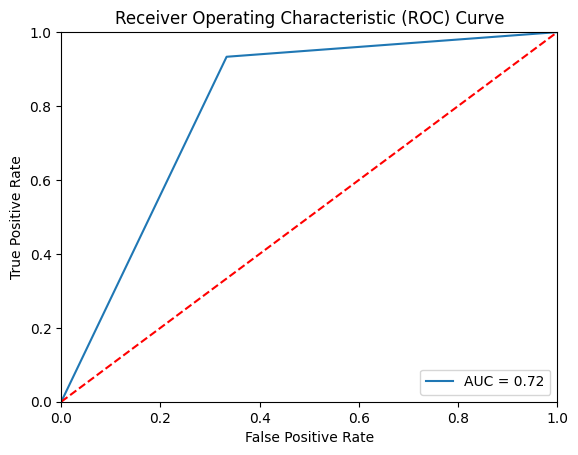

In [432]:
# Entrenar el modelo de regresión logística
logistic_reg_model = LogisticRegression(lr=0.03, num_iter=50000)
logistic_reg_model.fit(X_train_wines, y_train_wines)

# Realizar predicciones sobre los datos de prueba
y_pred_wines = logistic_reg_model.predict(X_test_wines, 0.6)

print("Exactitud: ",logistic_reg_model.score(y_pred_wines,y_test_wines))

print("Resultados obtenidos: ", y_pred_wines[:20])
print("Resultados esperados: ", y_test_wines[:20], "\n")

computeMetrics(y_test_wines, y_pred_wines)

### Set de datos Notas de Arquitectura de Computadores 1

In [408]:
# Cargar los datos de Arquitectura 1
data_arquiI_2021_s1 = pd.read_csv("2021-s1.csv", delimiter=';')
data_arquiI_2021_s2 = pd.read_csv("2021-s2.csv", delimiter=';')
data_arquiI_2022_s1 = pd.read_csv("2022-s1.csv", delimiter=';')
data_arquiI_2022_s2 = pd.read_csv("2022-s2.csv", delimiter=';')

#=======  Feature Engineering  =======#

# Feature Selection
# Conservar solo features que se toman en cuenta de cada archivo
data_arquiI_2021_s1 = data_arquiI_2021_s1.loc[:, ['Examen 1 15.0%', 'Tarea 1 3.75%',
       'Proyecto Individual Funcional 11.25%','Proyecto Grupal 1 Funcional 13.12%', 'Total: ']]
data_arquiI_2021_s2 = data_arquiI_2021_s2.loc[:, ['Examen 1 15.0%', 'Tarea 1', 
       'Proyecto Individual Funcional 11.25%','Proyecto Grupal 1 Funcional 13.12%', 'Total: ']]
data_arquiI_2022_s1 = data_arquiI_2022_s1.loc[:, ['Examen parcial 1 15%', 'Tarea 1 evaluación 3.75%',
       'Proyecto Individual Funcional 11.25%','Proyecto Grupal 1 Funcional 13.12%', 'Total: ']]
data_arquiI_2022_s2 = data_arquiI_2022_s2.loc[:, ['Examen parcial 1 15%', 'Tarea 1 3.75%',
       'Proyecto Individual Funcional 11.25%','Proyecto Grupal 1 Func Eval 13.12%', 'Total: ']]

# Renombrar columnas para combinarlas
data_arquiI_2021_s1 = data_arquiI_2021_s1.rename(columns={'Examen parcial 1 15%': 'Examen 1 15.0%'})
data_arquiI_2021_s2 = data_arquiI_2021_s2.rename(columns={'Tarea 1': 'Tarea 1 3.75%'})
data_arquiI_2022_s1 = data_arquiI_2022_s1.rename(columns={'Examen parcial 1 15%': 'Examen 1 15.0%', 
                            'Tarea 1 evaluación 3.75%': 'Tarea 1 3.75%'})
data_arquiI_2022_s2 = data_arquiI_2022_s2.rename(columns={'Examen parcial 1 15%': 'Examen 1 15.0%', 
                            'Proyecto Grupal 1 Func Eval 13.12%': 'Proyecto Grupal 1 Funcional 13.12%'})

# Combinar todos los datos en un solo set
data_arquiI_combined = pd.concat([data_arquiI_2021_s1, data_arquiI_2021_s2,
                                  data_arquiI_2022_s1, data_arquiI_2022_s2], 
                                  axis=0, ignore_index=True)

# Reemplazar espacios en blanco con NaN
data_arquiI_combined = data_arquiI_combined.replace(' ', np.nan)
# Eliminar filas que contengan al menos un NaN
data_arquiI_combined = data_arquiI_combined.dropna()
# Castear tipos de string a float
data_arquiI_combined = data_arquiI_combined.astype('float64')


# Convertir la calidad en un problema de clasificación binaria
data_arquiI_combined['Total: '] = np.where(data_arquiI_combined['Total: '] >= 67.5, 1, 0)

# Ajustar pesos
data_arquiI_combined['Examen 1 15.0%'] = data_arquiI_combined['Examen 1 15.0%']*0.15
data_arquiI_combined['Tarea 1 3.75%'] = data_arquiI_combined['Tarea 1 3.75%']*0.0375
data_arquiI_combined['Proyecto Individual Funcional 11.25%'] = data_arquiI_combined['Proyecto Individual Funcional 11.25%']*0.1125
data_arquiI_combined['Proyecto Grupal 1 Funcional 13.12%'] = data_arquiI_combined['Proyecto Grupal 1 Funcional 13.12%']*0.1312

data_arquiI_combined = data_arquiI_combined.rename(columns={'Total: ': 'Aprobado'})

data_arquiI_combined.head()

# Dividir los datos en conjunto de entrenamiento y prueba
X_train_arqui, X_test_arqui, y_train_arqui, y_test_arqui = train_test_split(data_arquiI_combined.drop('Aprobado', axis=1), 
    data_arquiI_combined['Aprobado'], test_size=0.2, stratify=data_arquiI_combined['Aprobado'])

X_train_arqui = X_train_arqui.values
X_test_arqui  = X_test_arqui.values
y_train_arqui = y_train_arqui.values
y_test_arqui  = y_test_arqui.values

Exactitud:  0.8333333333333334
Resultados obtenidos:  [ True  True False False  True  True False  True  True  True  True  True
  True  True False  True  True  True]
Resultados esperados:  [1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1] 

Exactitud:  0.8333333333333334
Precisión:  0.9285714285714286
Recall:  0.8666666666666667
AUC:  0.7666666666666668


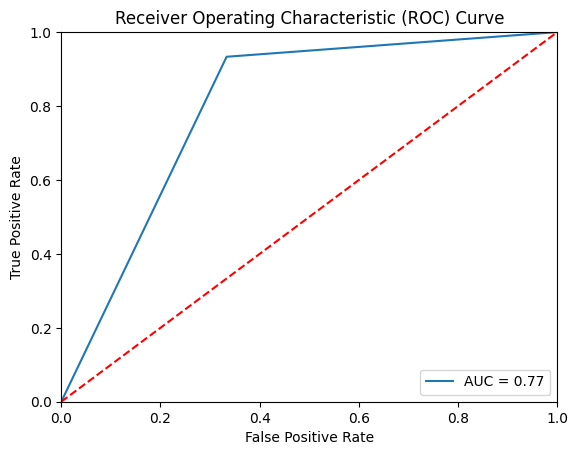

In [409]:
# Entrenar el modelo de regresión logística
logistic_reg_model = LogisticRegression(lr=0.03, num_iter=50000)
logistic_reg_model.fit(X_train_arqui, y_train_arqui)

# Realizar predicciones sobre los datos de prueba
y_pred_arqui = logistic_reg_model.predict(X_test_arqui, 0.6)

print("Exactitud: ",logistic_reg_model.score(y_pred_arqui,y_test_arqui))

print("Resultados obtenidos: ", y_pred_arqui[:20])
print("Resultados esperados: ", y_test_arqui[:20], "\n")

computeMetrics(y_test_arqui, y_pred_arqui)

### Set de datos Propio

In [447]:
# Cargar los datos de Red Wine Quality
data_heart = pd.read_csv("heart.csv")

#======  Feature Engineering  ======#
data_heart.columns
# Selección de features relevantes
#data_heart = data_heart.loc[:, ['GamesPlayed', 'MinutesPlayed', 'PointsPerGame',
#       'FieldGoalPercent','3PointPercent','FreeThrowPercent','target']]

## Estandarización de los datos
X = data_heart.drop(['target', 'sex', 'fbs', 'exang'], axis=1)
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
#scaler = MinMaxScaler()
scaler = StandardScaler()
scaler.fit(X[numeric_cols])
scaled_data = scaler.transform(X[numeric_cols])
data_heart[numeric_cols] = scaled_data
#data_heart = data_heart.drop('volatile acidity', axis=1)

print(data_heart.head())

# Dividir los datos en conjunto de entrenamiento y prueba
X_train_heart, X_test_heart, y_train_heart, y_test_heart = train_test_split(data_heart.drop('target', axis=1), 
    data_heart['target'], test_size=0.2, stratify=data_heart['target'])

X_train_heart = X_train_heart.values
X_test_heart  = X_test_heart.values
y_train_heart = y_train_heart.values
y_test_heart  = y_test_heart.values

        age  sex        cp  trestbps      chol  fbs   restecg   thalach  \
0  0.952197    1  1.973123  0.763956 -0.256334    1 -1.005832  0.015443   
1 -1.915313    1  1.002577 -0.092738  0.072199    0  0.898962  1.633471   
2 -1.474158    0  0.032031 -0.092738 -0.816773    0 -1.005832  0.977514   
3  0.180175    1  0.032031 -0.663867 -0.198357    0  0.898962  1.239897   
4  0.290464    0 -0.938515 -0.663867  2.082050    0  0.898962  0.583939   

   exang   oldpeak     slope        ca      thal  target  
0      0  1.087338 -2.274579 -0.714429 -2.148873       1  
1      0  2.122573 -2.274579 -0.714429 -0.512922       1  
2      0  0.310912  0.976352 -0.714429 -0.512922       1  
3      0 -0.206705  0.976352 -0.714429 -0.512922       1  
4      1 -0.379244  0.976352 -0.714429 -0.512922       1  


Exactitud:  0.7868852459016393
Resultados obtenidos:  [ True False False False  True False False False  True  True  True  True
  True False False False  True  True False  True]
Resultados esperados:  [1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 1] 

Exactitud:  0.7868852459016393
Precisión:  0.7941176470588235
Recall:  0.8181818181818182
AUC:  0.7840909090909092


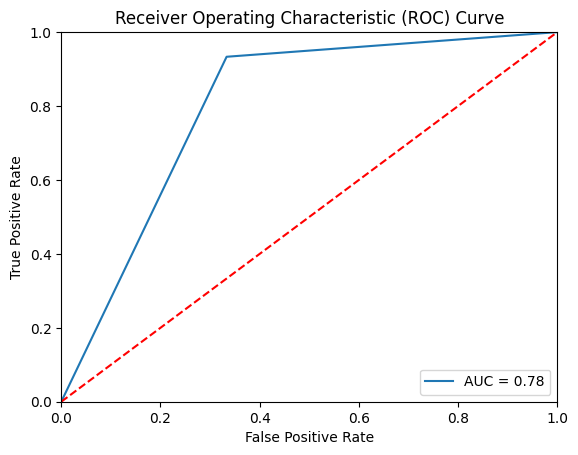

In [448]:
# Entrenar el modelo de regresión logística
logistic_reg_model = LogisticRegression(lr=0.03, num_iter=50000)
logistic_reg_model.fit(X_train_heart, y_train_heart)

# Realizar predicciones sobre los datos de prueba
y_pred_heart = logistic_reg_model.predict(X_test_heart, 0.6)

print("Exactitud: ",logistic_reg_model.score(y_pred_heart,y_test_heart))

print("Resultados obtenidos: ", y_pred_heart[:20])
print("Resultados esperados: ", y_test_heart[:20], "\n")

computeMetrics(y_test_heart, y_pred_heart)

## Árboles de decisión

In [7]:
# Función para dividir los datos en dos grupos en función de un valor de corte
def split_data(data, split_column, split_value):
    data_below = data[data[split_column] <= split_value]
    data_above = data[data[split_column] > split_value]
    return data_below, data_above

# Función para calcular la entropía de un conjunto de datos
def entropy(data, target_column):
    _, counts = np.unique(data[target_column], return_counts=True)
    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
    return entropy

# Función para calcular la ganancia de información al dividir un conjunto de datos en dos grupos
def information_gain(data, split_column, target_column):
    original_entropy = entropy(data, target_column)
    data_below, data_above = split_data(data, split_column, data[split_column].median())
    n = len(data)
    n_below = len(data_below)
    n_above = len(data_above)
    below_weight = n_below / n
    above_weight = n_above / n
    weighted_entropy = below_weight * entropy(data_below, target_column) + above_weight * entropy(data_above, target_column)
    information_gain = original_entropy - weighted_entropy
    return information_gain

# Función para encontrar el mejor atributo de división para un conjunto de datos
def find_best_split(data, target_column):
    information_gains = []
    for column in data.columns:
        if column == target_column:
            continue
        information_gain1 = information_gain(data, column, target_column)
        information_gains.append((column, information_gain1))
    best_split_column, best_information_gain = max(information_gains, key=lambda x: x[1])
    return best_split_column

# Función para crear un nodo de decisión en el árbol
def create_decision_node(data, target_column):
    # Si todos los valores en el conjunto de datos tienen la misma etiqueta, crear un nodo hoja
    if len(np.unique(data[target_column])) == 1:
        return data[target_column].iloc[0]
    
    # Si no hay más atributos para dividir, crear un nodo hoja con la etiqueta más común
    if len(data.columns) == 1:
        return np.bincount(data[target_column]).argmax()
    
    # Encontrar el mejor atributo de división para el conjunto de datos
    best_split_column = find_best_split(data, target_column)
    
    # Crear un nodo de decisión con el mejor atributo de división
    decision_node = {'split_column': best_split_column}
    median = data[best_split_column].median()
    decision_node['median'] = median
    
    # Dividir los datos en dos grupos
    data_below, data_above = split_data(data, best_split_column, median)
    
    # Recursivamente crear los hijos del nodo de decisión
    decision_node['below'] = create_decision_node(data_below, target_column)
    decision_node['above'] = create_decision_node(data_above, target_column)
    
    return decision_node

# Función para predecir la etiqueta de un ejemplo utilizando el árbol de decisión
def predict(example, decision_tree):
    if type(decision_tree) != dict:
        return decision_tree
    split_column = decision_tree['split_column']
    median = decision_tree['median']
    if example[split_column] <= median:
        return predict(example, decision_tree['below'])
    else:
        return predict(example, decision_tree['above'])


### Set de datos Red Wine Quality

In [8]:
# Leer los datos
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

# Dividir los datos en conjunto de entrenamiento y prueba
np.random.seed(0)
train_data = data.sample(frac=0.8)
test_data = data.drop(train_data.index)

# Separar los predictores y las etiquetas
X_train = train_data.drop('quality', axis=1)
y_train = train_data['quality']
X_test = test_data.drop('quality', axis=1)
y_test = test_data['quality']


In [9]:
# Crear el árbol de decisión a partir del conjunto de entrenamiento
decision_tree = create_decision_node(train_data, 'quality')

# Evaluar el árbol de decisión en el conjunto de prueba
y_pred = X_test.apply(lambda x: predict(x, decision_tree), axis=1)

In [10]:
# Calcular la precisión, recall y AUC
accuracy_data.append( accuracy_score(y_test, y_pred))
precision_data.append(precision_score(y_test, y_pred, average='weighted'))
recall_data.append(recall_score(y_test, y_pred, average='weighted'))
#auc_data.append(roc_auc_score(y_test, y_pred, multi_class='ovr'))

print(accuracy_data[1])
print(precision_data[1])
print(recall_data[1])
#print(auc_data[1])


0.628125
0.6129674238163412
0.628125


### Set de datos Notas de Arquitectura de Computadores 1

### Set de datos Propio

## KNN

In [382]:
class KNearestNeighbors():
    def __init__(self, X_train, y_train, n_neighbors=5, weights='uniform'):

        self.X_train = X_train
        self.y_train = y_train

        self.n_neighbors = n_neighbors
        self.weights = weights

        self.n_classes = 2

    def euclidian_distance(self, a, b):
        return np.sqrt(np.sum((a - b)**2, axis=1))

    def kneighbors(self, X_test, return_distance=False):

        dist = []
        neigh_ind = []

        #print(X_test, self.X_train. X_test, self.X_train)
        point_dist = []
        for x_test in X_test:
            point_dist += [ self.euclidian_distance(x_test, self.X_train) ]

        for row in point_dist:
            enum_neigh = enumerate(row)
            sorted_neigh = sorted(enum_neigh,
                                  key=lambda x: x[1])[:self.n_neighbors]
            #print("Sorted_neighs: ", sorted_neigh)
            ind_list = [tup[0] for tup in sorted_neigh]
            dist_list = [tup[1] for tup in sorted_neigh]

            dist.append(dist_list)
            neigh_ind.append(ind_list)

        if return_distance:
            return np.array(dist), np.array(neigh_ind)

        return np.array(neigh_ind)

    def predict(self, X_test):

        if self.weights == 'uniform':
            neighbors = self.kneighbors(X_test)
            y_pred = np.array([
                np.argmax(np.bincount(self.y_train[neighbor]))
                for neighbor in neighbors
            ])
            #print("Y_pred: ", y_pred)
            return y_pred

        if self.weights == 'distance':

            dist, neigh_ind = self.kneighbors(X_test, return_distance=True) #Obtener distancias y vecinos
            neighbors = []
            neighbors = [self.y_train[i] for i in neigh_ind] #Obtener los tipos segun los indices de vecinos
            
            y_pred = []
            for i in range(len(neighbors)):
                distances = {}                              #Diccionario para guardar distancias por tipo
                for j in range(len(neighbors[i])):
                    neighbor_type = neighbors[i][j]         #Obtener tipo de vecino
                    distance = dist[i][j]                   #Obtener distancia a dicho vecino
                    if neighbor_type in distances:          #Guardar en el diccionario
                        distances[neighbor_type].append(distance)
                    else:
                        distances[neighbor_type] = [distance]
                
                average_distances = {}                      #Diccionario para guardar promedio de distancias
                for neighbor_type in distances:
                    average_distance = np.mean(distances[neighbor_type])
                    average_distances[neighbor_type] = average_distance

                #Obtener minima distancia promedio 
                min_distance_type = min(average_distances, key=average_distances.get)
                #print("El tipo {} tiene la mínima distacia promedio y es: {}".format(min_distance_type, average_distances[min_distance_type]))
                y_pred.append(min_distance_type)

            return y_pred

    def score(self, X_test, y_test):
        y_pred = self.predict(X_test)
        return float(sum(y_pred == y_test)) / float(len(y_test)), y_pred, y_test


### Set de datos Red Wine Quality

Resultados obtenidos:  [1 1 1 1 1 1 0 0 1 0 1 1 0 1 0 0 0 1 1 0]
Resultados esperados:  [1 1 1 0 1 1 0 0 1 0 1 1 0 1 1 0 0 1 0 0] 

Exactitud:  0.753125
Precisión:  0.7527472527472527
Recall:  0.8011695906432749
AUC:  0.7495780839122416


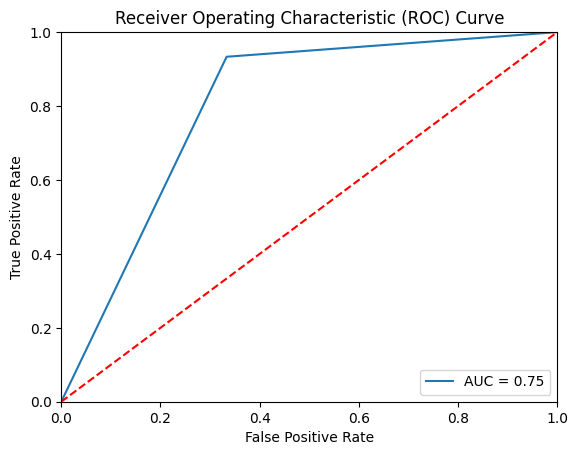

In [391]:
#Instanciar clasificador
distance_classifier = KNearestNeighbors(X_train_wines, y_train_wines, n_neighbors=7, weights='uniform')
distance_accuracy, y_pred, y_test_wines = distance_classifier.score(X_test_wines, y_test_wines)

print("Resultados obtenidos: ", y_pred[:20])
print("Resultados esperados: ", y_test_wines[:20], "\n")

computeMetrics(y_test_wines, y_pred)


### Set de datos Notas de Arquitectura de Computadores 1

Resultados obtenidos:  [1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1]
Resultados esperados:  [1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1] 

Exactitud:  0.8888888888888888
Precisión:  0.9333333333333333
Recall:  0.9333333333333333
AUC:  0.8


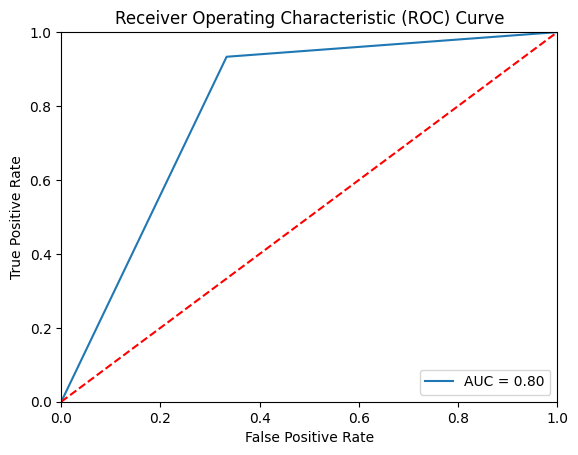

In [392]:
#Instanciar clasificador
distance_classifier = KNearestNeighbors(X_train_arqui, y_train_arqui, n_neighbors=7, weights='uniform')
distance_accuracy, y_pred, y_test_arqui = distance_classifier.score(X_test_arqui, y_test_arqui)

print("Resultados obtenidos: ", y_pred[:20])
print("Resultados esperados: ", y_test_arqui[:20], "\n")

computeMetrics(y_test_arqui, y_pred)

### Set de datos Propio

## Comparación con sklearn

### Regresión Logística Red Wine Quality Sklearn

In [393]:
def computeSklearnMetrics(y_test, y_pred):
    # Calcular la exactitud
    acc = accuracy_score(y_test, y_pred)
    accuracy_sklearn.append(acc)
    print("Exactitud: ",acc)

    # Calcular la precisión
    prec = precision_score(y_test, y_pred)
    precision_sklearn.append(prec)
    print("Precisión: ",prec)

    # Calcular el recall
    rec = recall_score(y_test, y_pred)
    recall_sklearn.append(rec)
    print("Recall: ", rec)

    # Calcular el AUC
    auc = roc_auc_score(y_test, y_pred)
    auc_sklearn.append(auc)

    print("AUC: ", auc)

    # Calcular la curva ROC
    plt.plot(fpr, tpr, label='AUC = %0.2f' % auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

/home/jose/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jose/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Los mejores parámetros son:  {'max_iter': 50}
Con el cual se obtine un score de:  0.7458854166666666
Precisión del algoritmo KNN: 0.74
Exactitud:  0.7375
Precisión:  0.7806451612903226
Recall:  0.7076023391812866
AUC:  0.7397072098590998


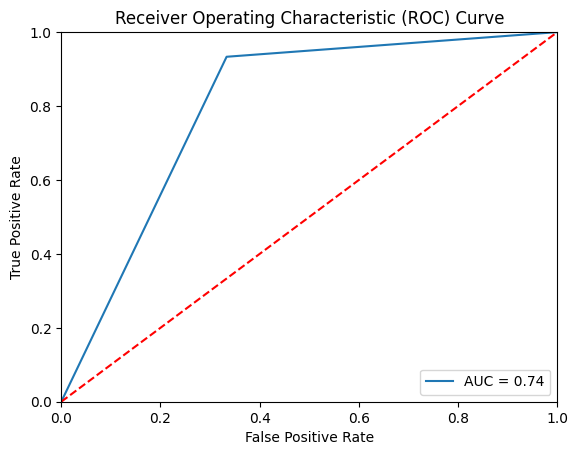

In [394]:
from sklearn.linear_model import LogisticRegression

# Instanciar clasificador de SKlearn
log_reg = LogisticRegression()

# Definir parámetros
param_grid = {
    'max_iter': [5, 50, 500, 750]
}

# Crear un GridSearchCV con cross-validation de 5
grid_search = GridSearchCV(log_reg, param_grid, cv=5)
grid_search.fit(X_train_wines, y_train_wines)

print("Los mejores parámetros son: ", grid_search.best_params_)
print("Con el cual se obtine un score de: ", grid_search.best_score_)

# Obtener el mejor clasificador
best_log_reg = grid_search.best_estimator_
y_pred = best_log_reg.predict(X_test_wines)
accuracy = best_log_reg.score(X_test_wines, y_test_wines)

print(f'Precisión del algoritmo KNN: {accuracy:.2f}')

computeSklearnMetrics(y_test_wines, y_pred)

### Regresión Logística Notas de Arquitectura de Computadores 1 Sklearn

/home/jose/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jose/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Los mejores parámetros son:  {'max_iter': 50}
Con el cual se obtine un score de:  0.9120879120879122
Exactitud:  0.8333333333333334
Precisión:  0.875
Recall:  0.9333333333333333
AUC:  0.6333333333333333


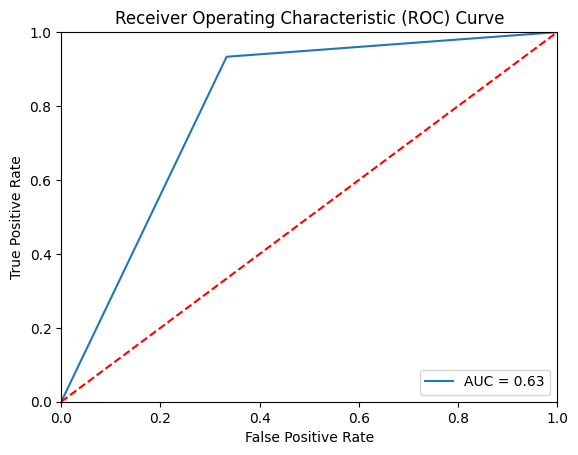

In [396]:
# Instanciar clasificador de SKlearn
log_reg = LogisticRegression()

# Definir parámetros
param_grid = {
    'max_iter': [5, 50, 500, 750]
}

# Crear un GridSearchCV con cross-validation de 5
grid_search = GridSearchCV(log_reg, param_grid, cv=5)
grid_search.fit(X_train_arqui, y_train_arqui)

print("Los mejores parámetros son: ", grid_search.best_params_)
print("Con el cual se obtine un score de: ", grid_search.best_score_)

# Obtener el mejor clasificador
best_log_reg = grid_search.best_estimator_
y_pred = best_log_reg.predict(X_test_arqui)

computeSklearnMetrics(y_test_arqui, y_pred)

### Regresión Logística Propio Sklearn

### Árboles de decisión Red Wine Quality

Los mejores parámetros son:  {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 4}
Con el cual se obtine un score de:  0.738875612745098
Precisión: 0.70
Accuracy:  0.734375
Precision:  0.7340848214285713
Recall:  0.734375


/home/jose/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


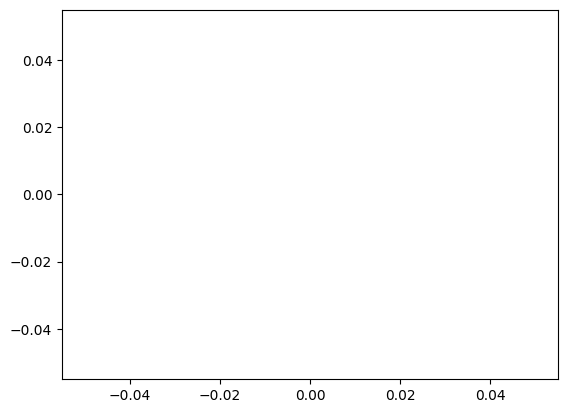

In [314]:
from sklearn.tree import DecisionTreeClassifier

# Instanciar clasificador de SKlearn
tree = DecisionTreeClassifier()

# Definir parámetros
param_grid = {
    'max_depth': [2, 4, 6, 8, 10, 12, 14],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

# Crear un GridSearchCV con cross-validation de 5
grid_search = GridSearchCV(tree, param_grid, cv=5)
grid_search.fit(X_train_wines, y_train_wines)

print("Los mejores parámetros son: ", grid_search.best_params_)
print("Con el cual se obtine un score de: ", grid_search.best_score_)

# Obtener el mejor clasificador
best_tree = grid_search.best_estimator_
y_pred = best_tree.predict(X_test_wines)
accuracy = best_tree.score(X_test_wines, y_test_wines)

print(f'Precisión: {accuracy:.2f}')


#-------------------------------------------------------------------------------------------------
# Calcular las métricas de evaluación
# Calcular la precisión, recall y AUC
accuracy_sklearn.append( accuracy_score(y_test_wines, y_pred))
precision_sklearn.append(precision_score(y_test_wines, y_pred, average='weighted'))
recall_sklearn.append(recall_score(y_test_wines, y_pred, average='weighted'))
#auc_sklearn.append(roc_auc_score(y_test, y_pred, multi_class='ovr'))

print("Accuracy: ", accuracy_sklearn[2])
print("Precision: ", precision_sklearn[2])
print("Recall: ", recall_sklearn[2])
#print(auc_sklearn[2])

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test_wines, y_pred, pos_label=2)
plt.scatter(fpr, tpr, color='red')

### Árboles de decisión Notas de Arquitectura de Computadores 1 Sklearn

### Árboles de decisión Propio Sklearn

### KNN Red Wine Quality Sklearn

Los mejores parámetros son:  {'n_neighbors': 25, 'weights': 'distance'}
Con el cual se obtine un score de:  0.7904626225490196
Precisión del algoritmo KNN: 0.79
Exactitud:  0.7875
Precisión:  0.8198757763975155
Recall:  0.7719298245614035
AUC:  0.788649476039091


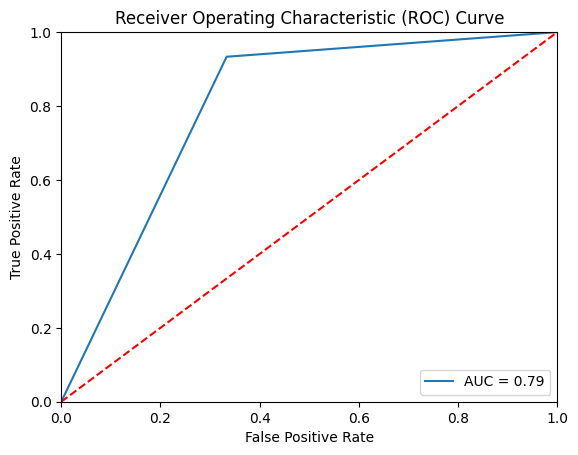

In [397]:
from sklearn.neighbors import KNeighborsClassifier

# Instanciar clasificador de SKlearn
knn = KNeighborsClassifier()

# Definir parámetros
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35],
    'weights': ['uniform', 'distance']
}

# Crear un GridSearchCV con cross-validation de 5
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train_wines, y_train_wines)

print("Los mejores parámetros son: ", grid_search.best_params_)
print("Con el cual se obtine un score de: ", grid_search.best_score_)

# Obtener el mejor clasificador
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test_wines)
accuracy = best_knn.score(X_test_wines, y_test_wines)

print(f'Precisión del algoritmo KNN: {accuracy:.2f}')

computeSklearnMetrics(y_test_wines, y_pred)

### KNN Notas de Arquitectura de Computadores 1 Sklearn

Los mejores parámetros son:  {'n_neighbors': 17, 'weights': 'distance'}
Con el cual se obtine un score de:  0.9417582417582417
Precisión del algoritmo KNN: 0.89
Exactitud:  0.8888888888888888
Precisión:  0.9333333333333333
Recall:  0.9333333333333333
AUC:  0.8


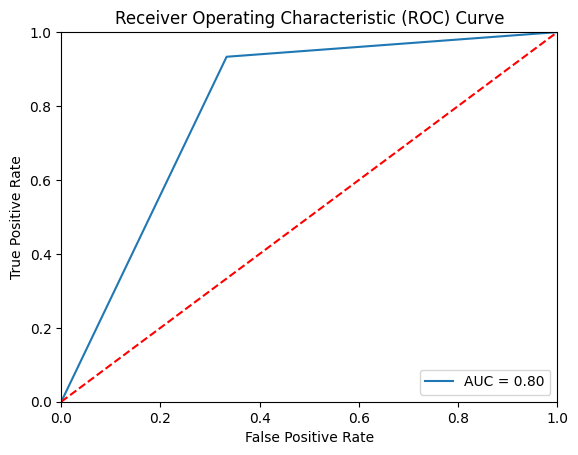

In [398]:
# Instanciar clasificador de SKlearn
knn = KNeighborsClassifier()

# Definir parámetros
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35],
    'weights': ['uniform', 'distance']
}

# Crear un GridSearchCV con cross-validation de 5
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train_arqui, y_train_arqui)

print("Los mejores parámetros son: ", grid_search.best_params_)
print("Con el cual se obtine un score de: ", grid_search.best_score_)

# Obtener el mejor clasificador
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test_arqui)
accuracy = best_knn.score(X_test_arqui, y_test_arqui)

print(f'Precisión del algoritmo KNN: {accuracy:.2f}')

computeSklearnMetrics(y_test_arqui, y_pred)

### KNN Propio Sklearn

## Tabla Comparativa

In [ ]:
k_values=[0,1,2]

accuracy = [0,0,0,0,0,0,0,0,0]
precision = [0,0,0,0,0,0,0,0,0]
recall = [0,0,0,0,0,0,0,0,0]
auc = [0,0,0,0,0,0,0,0,0]

accuracy_sklearn = [0,0,0,0,0,0,0,0,0]
precision_sklearn = [0,0,0,0,0,0,0,0,0]
recall_sklearn = [0,0,0,0,0,0,0,0,0]
auc_sklearn = [0,0,0,0,0,0,0,0,0]

print("Comparación de datos y algoritmos")
accuracy_data = {
  "Accuracy": accuracy,
  "Precision": precision,
  "Recall": recall,
  "AUC": auc,
  "Accuracy_sklearn": accuracy_sklearn,
  "Precision_sklearn": precision_sklearn,
  "Recall_sklearn": recall_sklearn,
  "AUC_sklearn": auc_sklearn
}
pd.DataFrame( accuracy_data,index = ["Regresión Logística: Red wine Quality", "Regresión Logística: Notas Arqui", "Regresión Logística: Propio", 
                                             "Árboles de decisión: Red wine Quality", "Árboles de decisión: Notas Arqui", "Árboles de decisión: Propio", 
                                             "KNN: Red wine Quality", "KNN: Notas Arqui", "KNN: Propio"])

Comparación de datos y algoritmos


,Accuracy,Precision,Recall,AUC,Accuracy_sklearn,Precision_sklearn,Recall_sklearn,AUC_sklearn
Regresión Logística: Red wine Quality,0,0,0,0,0,0,0,0
Regresión Logística: Notas Arqui,0,0,0,0,0,0,0,0
Regresión Logística: Propio,0,0,0,0,0,0,0,0
Árboles de decisión: Red wine Quality,0,0,0,0,0,0,0,0
Árboles de decisión: Notas Arqui,0,0,0,0,0,0,0,0
Árboles de decisión: Propio,0,0,0,0,0,0,0,0
KNN: Red wine Quality,0,0,0,0,0,0,0,0
KNN: Notas Arqui,0,0,0,0,0,0,0,0
KNN: Propio,0,0,0,0,0,0,0,0


## Puntos Extra